Simulated BGS galaxy spectra are generated using dark and bright sky spectrum then 
run through the `redrock` pipeline in order to measure redshifts. 



In [47]:
import os
import numpy as np 
# -- astropy --
from astropy.io import fits
from desispec.io import read_spectra
from desispec.io import write_spectra
from desispec.spectra import Spectra
# -- local --
from feasibgs import util as UT
from feasibgs import catalogs as Cat
from feasibgs import forwardmodel as FM

In [2]:
import matplotlib as mpl 
import matplotlib.pyplot as pl 
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False
%matplotlib inline

Read in Gama-Legacy catalog

In [3]:
cata = Cat.GamaLegacy()
gleg = cata.Read()

In [4]:
redshift = gleg['gama-spec']['z_helio']
ngal = len(redshift)

In [5]:
r_mag = UT.flux2mag(gleg['legacy-photo']['apflux_r'][:,1])

Read in the `redrock` redshift measurements for a subsample of the simulated spectra 

In [6]:
f_z_dark = ''.join([UT.dat_dir(), 'redrock/', 'gama_legacy.expSpectra.darksky.seed1.1of40blocks.zbest.fits'])
zdark_data = fits.open(f_z_dark)[1].data

f_i_dark = ''.join([UT.dat_dir(), 'spectra/', 'gama_legacy.expSpectra.darksky.seed1.1of40blocks.index'])
i_dark = np.loadtxt(f_i_dark, unpack=True, usecols=[0], dtype='i')

f_z_bright = ''.join([UT.dat_dir(), 'redrock/', 'gama_legacy.expSpectra.brightsky.seed1.1of40blocks.zbest.fits'])
zbright_data = fits.open(f_z_bright)[1].data

f_i_bright = ''.join([UT.dat_dir(), 'spectra/', 'gama_legacy.expSpectra.brightsky.seed1.1of40blocks.index']) 
i_bright = np.loadtxt(f_i_bright, unpack=True, usecols=[0], dtype='i')

In [7]:
print('%i redshifts' % len(zdark_data['Z']))

994 redshifts


In [8]:
assert np.array_equal(i_dark, i_bright)

In [9]:
z_gama = redshift[i_dark]

A number of galaxies have no fiber flux, so lets impose a magnitude cut

In [10]:
mag_cut = (r_mag[i_dark] < 25.0)
print('%f remain after mag cut' % (float(np.sum(mag_cut))/float(len(i_dark))))
print('%i galaxies remaining' % np.sum(mag_cut))

0.901408 remain after mag cut
896 galaxies remaining


(17, 22.0)

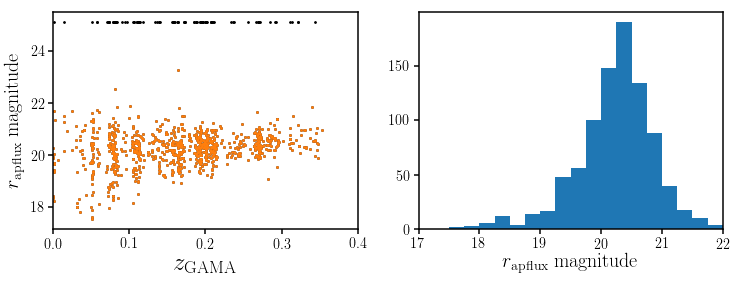

In [11]:
fig = plt.figure(figsize=(12,4))
sub1 = fig.add_subplot(121)
sub1.scatter(z_gama, r_mag[i_dark], s=3, c='k')
sub1.scatter(z_gama[mag_cut], r_mag[i_dark][mag_cut], s=3, c='C1')
sub1.set_xlabel(r'$z_\mathrm{GAMA}$', fontsize=25)
sub1.set_xlim([0., 0.4])
sub1.set_ylabel(r'$r_\mathrm{apflux}$ magnitude', fontsize=20)
sub2 = fig.add_subplot(122)
_ = sub2.hist(r_mag[i_dark][mag_cut], histtype='stepfilled', range=(17, 22), bins=20)
sub2.set_xlabel(r'$r_\mathrm{apflux}$ magnitude', fontsize=20)
sub2.set_xlim([17, 22.])

Lets compare the redshift we measure from redrock to the "true" input redshift from GAMA. 

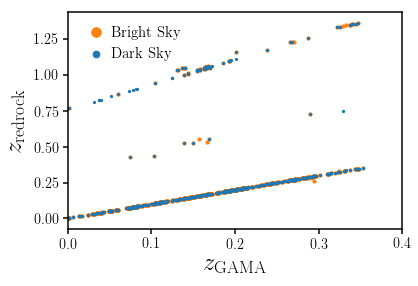

In [12]:
fig = plt.figure()
sub = fig.add_subplot(111)
sub.scatter(z_gama[mag_cut], zbright_data['Z'][mag_cut], c='C1', s=10, label='Bright Sky')
sub.scatter(z_gama[mag_cut], zdark_data['Z'][mag_cut], c='C0', s=5, label='Dark Sky')
sub.set_xlabel(r"$z_\mathrm{GAMA}$", fontsize=25)
sub.set_xlim([0., 0.4])
sub.set_ylabel(r"$z_\mathrm{redrock}$", fontsize=25)
sub.legend(loc='upper left', markerscale=3, handletextpad=0., prop={'size':15})

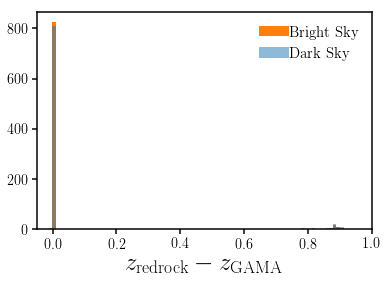

In [25]:
fig = plt.figure()
sub = fig.add_subplot(111)
_ = sub.hist(zbright_data['Z'][mag_cut] - z_gama[mag_cut], color='C1', 
             range=(-0.1, 1.0), bins=100, histtype='stepfilled', label='Bright Sky')
_ = sub.hist(zdark_data['Z'][mag_cut] - z_gama[mag_cut], color='C0', 
             range=(-0.1, 1.0), bins=100, histtype='stepfilled', alpha=0.5, label='Dark Sky')
sub.set_xlabel(r"$z_\mathrm{redrock} - z_\mathrm{GAMA}$", fontsize=25)
sub.set_xlim([-0.05, 1.])
sub.legend(loc='upper right', markerscale=3, handletextpad=0., prop={'size':15})

In [26]:
print('Dark Sky: %i galaxies have Delta z > 0.1' % np.sum(zdark_data['Z'][mag_cut] - z_gama[mag_cut] > 0.1))
print('Bright Sky: %i galaxies have Delta z > 0.1' % np.sum(zbright_data['Z'][mag_cut] - z_gama[mag_cut] > 0.1))

Dark Sky: 84 galaxies have Delta z > 0.1
Bright Sky: 66 galaxies have Delta z > 0.1


Based on $\Delta z$, `redrock` recovers redshifts is more successfully for spectra observed with bright sky...

In [27]:
dz_1pz_dark = (zdark_data['Z'] - z_gama)/(1.+z_gama)
dz_1pz_bright = (zbright_data['Z'] - z_gama)/(1.+z_gama)

Text(0,0.5,'$\\Delta z / (1+z_\\mathrm{GAMA})$')

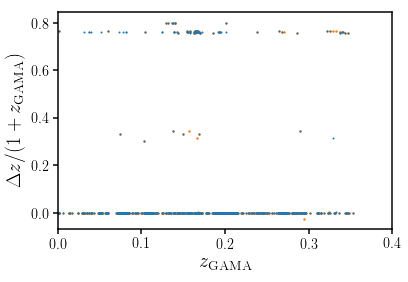

In [28]:
plt.scatter(z_gama[mag_cut], dz_1pz_bright[mag_cut], c='C1', s=2)
plt.scatter(z_gama[mag_cut], dz_1pz_dark[mag_cut], c='C0', s=1)
plt.xlabel(r"$z_\mathrm{GAMA}$", fontsize=20)
plt.xlim([0.,0.4])
plt.ylabel(r"$\Delta z / (1+z_\mathrm{GAMA})$", fontsize=20)

In [29]:
print('Dark Sky: %i galaxies have dz/(1+z) > 0.1' % np.sum(dz_1pz_dark[mag_cut] > 0.1))
print('Bright Sky: %i galaxies have dz/(1+z) > 0.1' % np.sum(dz_1pz_bright[mag_cut] > 0.1))

Dark Sky: 84 galaxies have dz/(1+z) > 0.1
Bright Sky: 66 galaxies have dz/(1+z) > 0.1


Also based on $\Delta z/(1+z)$, `redrock` recovers redshifts is more successfully for spectra observed with bright sky...

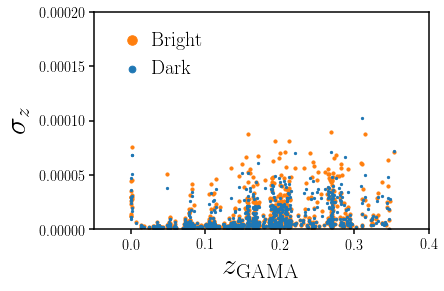

In [30]:
plt.scatter(z_gama[mag_cut], zbright_data['ZERR'][mag_cut], c='C1', s=10, label='Bright')
plt.scatter(z_gama[mag_cut], zdark_data['ZERR'][mag_cut], c='C0', s=5, label='Dark')
plt.xlabel(r"$z_\mathrm{GAMA}$", fontsize=30)
plt.xlim([-0.05, 0.4])
plt.ylabel(r"$\sigma_z$", fontsize=30)
plt.ylim([0, 2e-4])
plt.legend(loc='upper left', markerscale=3, handletextpad=0.0, prop={'size': 20})

At least, the redshift measurement from `redrock` have larger uncertainties for the bright sky. 

Now lets see the redshift success rate (quantified as $\Delta z/(1+z) < 0.01$) as a function of various parameters. 

In [31]:
def gethist(var, ztrue, zbest, range=None):
    """Generate the histogram (and Poisson uncertainty) for various 
    sample cuts.  See zstats() for details.

    """
    dz = zbest - ztrue
    dz_1pz = np.abs(dz)/(1.+ztrue)
    s1 = (dz_1pz < 0.003)
    
    h0, bins = np.histogram(var, bins=20, range=range)
    hv, _ = np.histogram(var, bins=bins, weights=var)
    h1, _ = np.histogram(var[s1], bins=bins)

    good = h0 > 2
    hv = hv[good]
    h0 = h0[good]
    h1 = h1[good]

    vv = hv / h0
    
    def _eff(k, n):
        eff = k.astype("float") / (n.astype('float') + (n==0))
        efferr = np.sqrt(eff * (1 - eff)) / np.sqrt(n.astype('float') + (n == 0))
        return eff, efferr
    
    e1, ee1 = _eff(h1, h0)

    return vv, e1, ee1

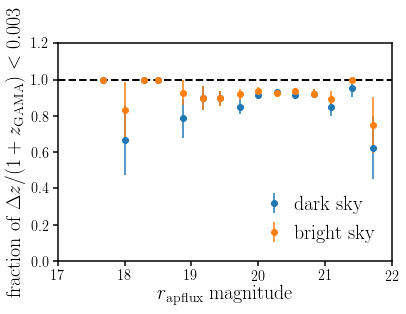

In [32]:
mm_dark, e1_dark, ee1_dark = gethist(r_mag[i_dark][mag_cut], z_gama[mag_cut], zdark_data['Z'][mag_cut])
mm_bright, e1_bright, ee1_bright = gethist(r_mag[i_dark][mag_cut], z_gama[mag_cut], zbright_data['Z'][mag_cut])

fig = plt.figure()
sub = fig.add_subplot(111)
sub.plot([17., 22.], [1., 1.], c='k', ls='--', lw=2)
sub.errorbar(mm_dark, e1_dark, ee1_dark, c='C0', fmt='o', label="dark sky")
sub.errorbar(mm_bright, e1_bright, ee1_bright, c='C1', fmt='o', label="bright sky")
sub.set_xlabel(r'$r_\mathrm{apflux}$ magnitude', fontsize=20)
sub.set_xlim([17., 22.])
sub.set_ylabel(r'fraction of $\Delta z /(1+z_\mathrm{GAMA}) < 0.003$', fontsize=20)
sub.set_ylim([0., 1.2])
sub.legend(loc='lower right', handletextpad=0., prop={'size': 20})

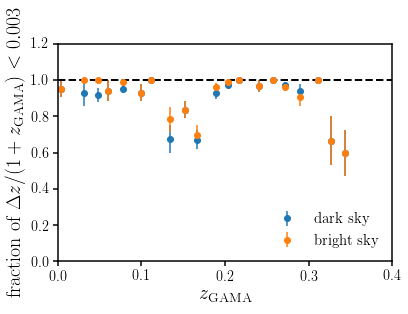

In [33]:
mm_dark, e1_dark, ee1_dark = gethist(redshift[i_dark][mag_cut], z_gama[mag_cut], zdark_data['Z'][mag_cut])
mm_bright, e1_bright, ee1_bright = gethist(redshift[i_dark][mag_cut], z_gama[mag_cut], zbright_data['Z'][mag_cut])

fig = plt.figure()
sub = fig.add_subplot(111)
sub.plot([0., 0.5], [1., 1.], c='k', ls='--', lw=2)
sub.errorbar(mm_dark, e1_dark, ee1_dark, c='C0', fmt='o', label="dark sky")
sub.errorbar(mm_bright, e1_bright, ee1_bright, c='C1', fmt='o', label="bright sky")
sub.set_xlabel(r'$z_\mathrm{GAMA}$', fontsize=20)
sub.set_xlim([0.0, 0.4])
sub.set_ylabel(r'fraction of $\Delta z /(1+z_\mathrm{GAMA}) < 0.003$', fontsize=20)
sub.set_ylim([0., 1.2])
sub.legend(loc='lower right', prop={'size': 15})

In [34]:
gama_ha = gleg['gama-spec']['ha']
legacy_g = UT.flux2mag(gleg['legacy-photo']['flux_g'])#, method='log')
legacy_r = UT.flux2mag(gleg['legacy-photo']['flux_r'])#, method='log')
legacy_gr = legacy_g - legacy_r

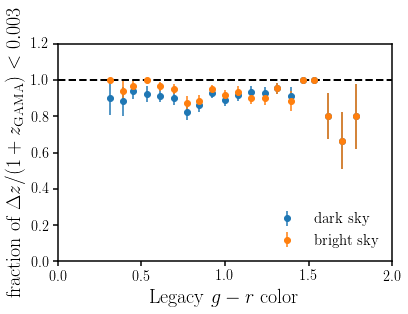

In [35]:
mm_dark, e1_dark, ee1_dark = gethist(legacy_gr[i_dark][mag_cut], z_gama[mag_cut], zdark_data['Z'][mag_cut])
mm_bright, e1_bright, ee1_bright = gethist(legacy_gr[i_dark][mag_cut], z_gama[mag_cut], zbright_data['Z'][mag_cut])

fig = plt.figure()
sub = fig.add_subplot(111)
sub.plot([0., 2.], [1., 1.], c='k', ls='--', lw=2)
sub.errorbar(mm_dark, e1_dark, ee1_dark, c='C0', fmt='o', label="dark sky")
sub.errorbar(mm_bright, e1_bright, ee1_bright, c='C1', fmt='o', label="bright sky")
sub.set_xlabel(r'Legacy $g-r$ color', fontsize=20)
sub.set_xlim([0., 2.])
sub.set_ylabel(r'fraction of $\Delta z /(1+z_\mathrm{GAMA}) < 0.003$', fontsize=20)
sub.set_ylim([0., 1.2])
sub.legend(loc='lower right', prop={'size': 15})

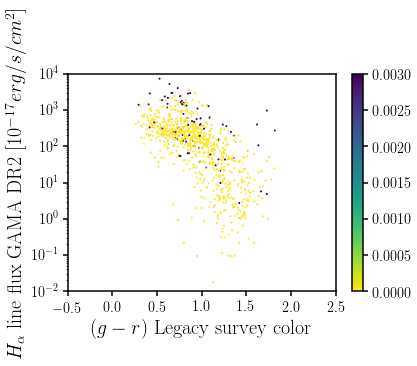

In [36]:
fig = plt.figure()
sub = fig.add_subplot(111)
cc = sub.scatter(legacy_gr[i_dark][mag_cut], gama_ha[i_dark][mag_cut], s=1, c=dz_1pz_dark[mag_cut], 
                 cmap='viridis_r', vmin=0, vmax=0.003)
sub.set_xlabel('$(g-r)$ Legacy survey color', fontsize=20)
sub.set_xlim([-0.5, 2.5])
sub.set_ylabel(r'$H_\alpha$ line flux GAMA DR2 $[10^{-17}erg/s/cm^2]$', fontsize=20)
sub.set_ylim([1e-2, 1e4])
sub.set_yscale('log')
fig.colorbar(cc)

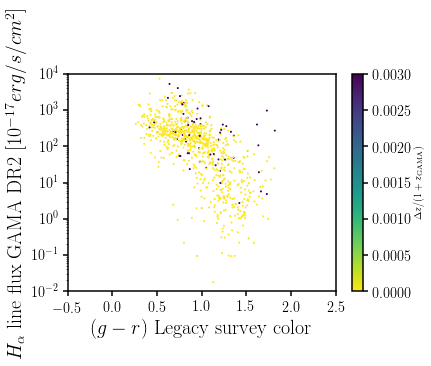

In [37]:
fig = plt.figure()
sub = fig.add_subplot(111)
cc = sub.scatter(legacy_gr[i_dark][mag_cut], gama_ha[i_dark][mag_cut], s=1, c=dz_1pz_bright[mag_cut], 
                 cmap='viridis_r', vmin=0, vmax=0.003)
sub.set_xlabel('$(g-r)$ Legacy survey color', fontsize=20)
sub.set_xlim([-0.5, 2.5])
sub.set_ylabel(r'$H_\alpha$ line flux GAMA DR2 $[10^{-17}erg/s/cm^2]$', fontsize=20)
sub.set_ylim([1e-2, 1e4])
sub.set_yscale('log')
fig.colorbar(cc, label=r'$\Delta z/(1+z_\mathrm{GAMA})$')

Lets compare the spectra w/ bright sky versus spectra w/ dark sky, for cases where the bright sky spectra produces more accurate redshifts

In [38]:
spec_dark = read_spectra(''.join([UT.dat_dir(), 'spectra/', 'gama_legacy.expSpectra.darksky.seed1.1of40blocks.fits']))
spec_bright = read_spectra(''.join([UT.dat_dir(), 'spectra/', 'gama_legacy.expSpectra.brightsky.seed1.1of40blocks.fits']))

In [39]:
weird = (np.abs(dz_1pz_bright) < np.abs(dz_1pz_dark)) & mag_cut
print('weird %i' % np.sum(weird))
veryweird = (dz_1pz_dark - dz_1pz_bright > 0.01) & mag_cut
print('very weird %i ' % np.sum(veryweird))
notveryweird = (dz_1pz_bright - dz_1pz_dark > 0.01) & mag_cut
print('not very weird %i' % np.sum(notveryweird)) 

weird 636
very weird 25 
not very weird 7


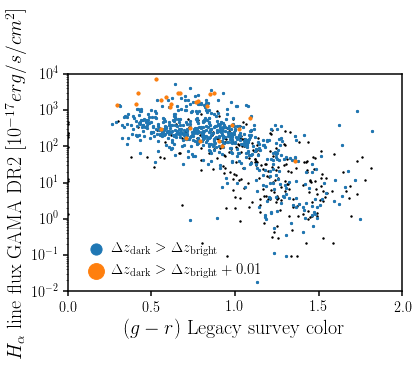

In [40]:
fig = plt.figure()
sub = fig.add_subplot(111)
sub.scatter(legacy_gr[i_dark], gama_ha[i_dark], s=2, c='k')
sub.scatter(legacy_gr[i_dark][weird], gama_ha[i_dark][weird], s=5, c='C0', 
            label='$\Delta z_\mathrm{dark} > \Delta z_\mathrm{bright}$')
sub.scatter(legacy_gr[i_dark][veryweird], gama_ha[i_dark][veryweird], s=10, c='C1', 
            label='$\Delta z_\mathrm{dark} > \Delta z_\mathrm{bright} + 0.01$')
sub.set_xlabel('$(g-r)$ Legacy survey color', fontsize=20)
sub.set_xlim([0, 2.])
sub.set_ylabel(r'$H_\alpha$ line flux GAMA DR2 $[10^{-17}erg/s/cm^2]$', fontsize=20)
sub.set_ylim([1e-2, 1e4])
sub.set_yscale('log')
sub.legend(loc='lower left', markerscale=5, handletextpad=0., prop={'size': 15})

Gama-Legacy index = 423
Gama-Legacy index = 484
Gama-Legacy index = 580
Gama-Legacy index = 628
Gama-Legacy index = 636


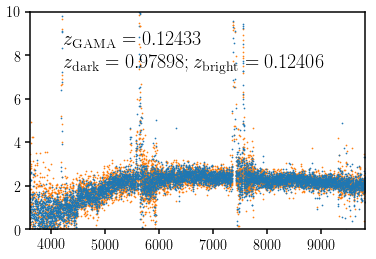

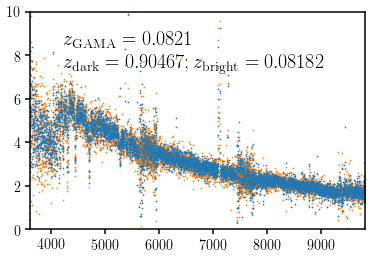

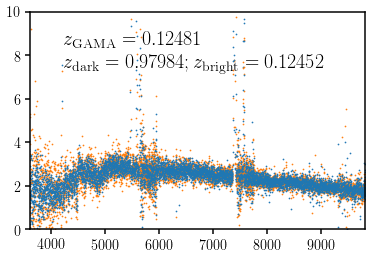

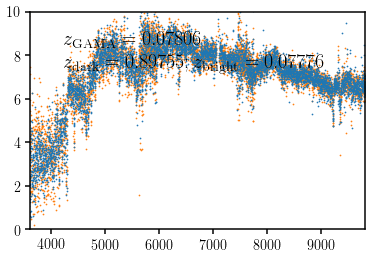

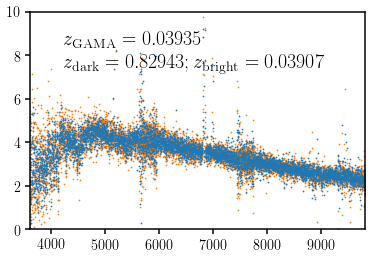

In [43]:
for i in np.arange(spec_dark.flux['b'].shape[0])[veryweird][10:15]: 
    fig = plt.figure()
    sub = fig.add_subplot(111)
    for band in ['b', 'r', 'z']:
        sub.scatter(spec_bright.wave[band], spec_bright.flux[band][i].flatten(), c='C1', s=0.5)
        sub.scatter(spec_dark.wave[band], spec_dark.flux[band][i].flatten(), c='C0', s=0.5)
    print('Gama-Legacy index = %i' % i_dark[i])
    #print(spec_bright.fibermap[i])
    #print(spec_dark.fibermap[i])
    sub.text(0.1, 0.9, 
             r'$z_\mathrm{GAMA}='+str(redshift[i_dark[i]])+'$ \n $z_\mathrm{dark}='+str(round(zdark_data['Z'][i],5))+'; z_\mathrm{bright} = '+str(round(zbright_data['Z'][i],5))+'$', 
             ha='left', va='top', fontsize=20, transform=sub.transAxes)
    sub.set_xlim([3600., 9800.])
    sub.set_ylim([0., 10.])

Gama-Legacy index = 89
Gama-Legacy index = 122
Gama-Legacy index = 180
Gama-Legacy index = 187


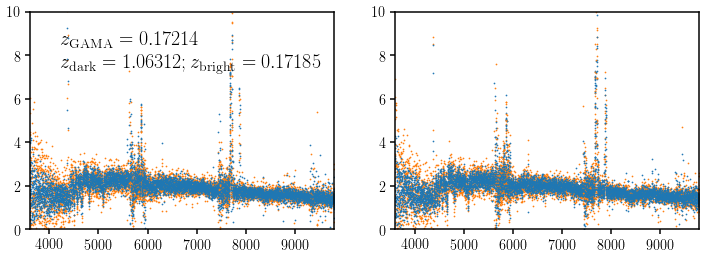

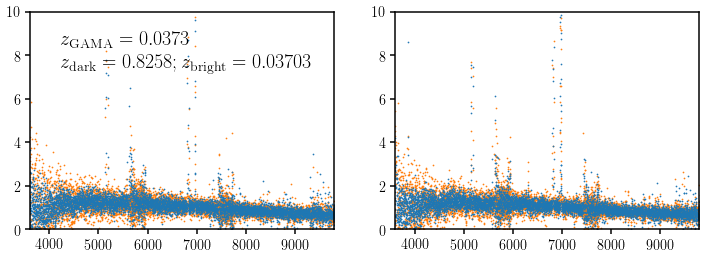

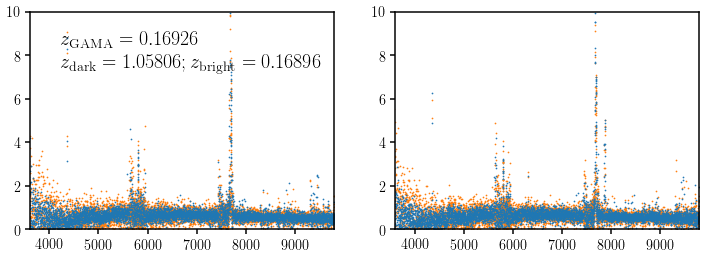

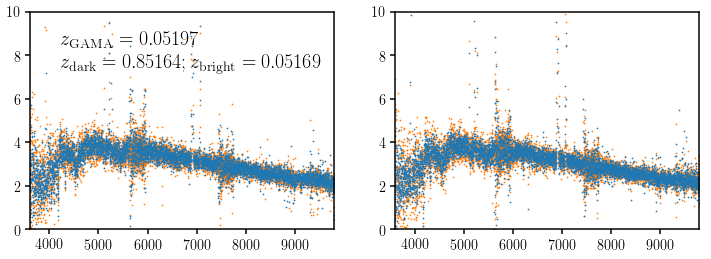

In [42]:
for i in np.arange(spec_dark.flux['b'].shape[0])[veryweird][:4]: 
    fig = plt.figure(figsize=(12,4))
    sub = fig.add_subplot(121)
    for band in ['b', 'r', 'z']:
        sub.scatter(spec_bright.wave[band], spec_bright.flux[band][i].flatten(), c='C1', s=0.5)
        sub.scatter(spec_dark.wave[band], spec_dark.flux[band][i].flatten(), c='C0', s=0.5)
    print('Gama-Legacy index = %i' % i_dark[i])
    sub.set_xlim([3600., 9800.])
    sub.set_ylim([0., 10.])
    sub.text(0.1, 0.9, 
             r'$z_\mathrm{GAMA}='+str(redshift[i_dark[i]])+'$ \n $z_\mathrm{dark}='+str(round(zdark_data['Z'][i],5))+'; z_\mathrm{bright} = '+str(round(zbright_data['Z'][i],5))+'$', 
             ha='left', va='top', fontsize=20, transform=sub.transAxes)
    
    obj_bright = read_spectra(''.join([UT.dat_dir(), 'obj', str(i_dark[i]), '.brightsky.fits']))
    obj_dark = read_spectra(''.join([UT.dat_dir(), 'obj', str(i_dark[i]), '.darksky.fits']))
    sub = fig.add_subplot(122)
    for band in ['b', 'r', 'z']:
        sub.scatter(obj_bright.wave[band], obj_bright.flux[band][0].flatten(), c='C1', s=0.5)
        sub.scatter(obj_dark.wave[band], obj_dark.flux[band][0].flatten(), c='C0', s=0.5)
    
    sub.set_xlim([3600., 9800.])
    sub.set_ylim([0., 10.])

In [60]:
print spec_dark.extra

None


In [82]:
for i in np.arange(spec_dark.flux['b'].shape[0])[veryweird]: 
    for i_spec, spec in enumerate([spec_bright, spec_dark]): 
        flux_dict = {} 
        ivar_dict = {}
        reso_dict = {}
        mask_dict = {}
        for band in ['b', 'r', 'z']:
            flux_dict[band] = spec.flux[band][i,:].reshape(1,-1)
            ivar_dict[band] = spec.ivar[band][i,:].reshape(1,-1)
            reso_dict[band] = np.array([spec.resolution_data[band][i,:,:]])
            mask_dict[band] = spec.mask[band][i,:].reshape(1,-1)
        ss = Spectra(bands=['b', 'r', 'z'], wave=spec.wave, flux=flux_dict, ivar=ivar_dict, mask=mask_dict, 
               resolution_data=reso_dict, fibermap=spec.fibermap[np.array([i])], meta=spec.meta, extra=None, single=spec._single)
        if i_spec == 0: 
            write_spectra(''.join([UT.dat_dir(), 'weird_obj', str(i_dark[i]), '.brightsky.fits']), ss)
        elif i_spec == 1: 
            write_spectra(''.join([UT.dat_dir(), 'weird_obj', str(i_dark[i]), '.darksky.fits']), ss)

Gama-Legacy index = 89
Gama-Legacy index = 122
Gama-Legacy index = 180
Gama-Legacy index = 187


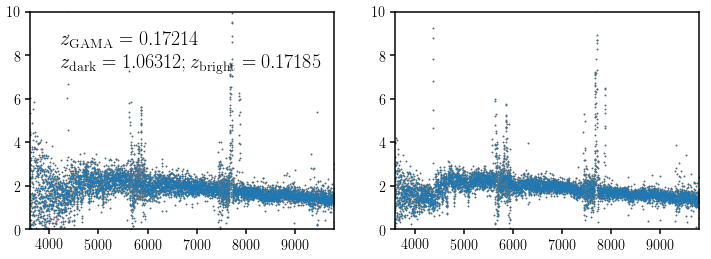

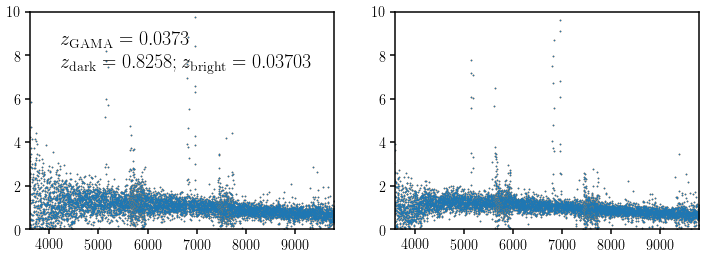

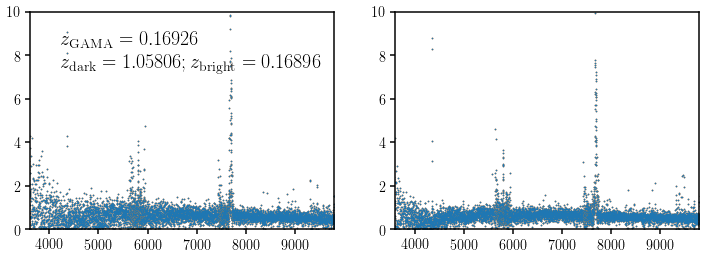

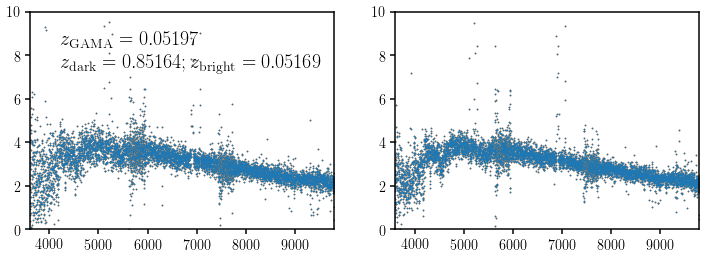

In [85]:
for i in np.arange(spec_dark.flux['b'].shape[0])[veryweird][:4]: 
    obj_bright = read_spectra(''.join([UT.dat_dir(), 'weird_obj', str(i_dark[i]), '.brightsky.fits']))
    obj_dark = read_spectra(''.join([UT.dat_dir(), 'weird_obj', str(i_dark[i]), '.darksky.fits']))
    
    fig = plt.figure(figsize=(12,4))
    sub = fig.add_subplot(121)
    for band in ['b', 'r', 'z']:
        sub.scatter(spec_bright.wave[band], spec_bright.flux[band][i].flatten(), c='C1', s=0.5)
        sub.scatter(obj_bright.wave[band], obj_bright.flux[band][0].flatten(), c='C0', s=0.5)

    print('Gama-Legacy index = %i' % i_dark[i])
    sub.set_xlim([3600., 9800.])
    sub.set_ylim([0., 10.])
    sub.text(0.1, 0.9, 
             r'$z_\mathrm{GAMA}='+str(redshift[i_dark[i]])+'$ \n $z_\mathrm{dark}='+str(round(zdark_data['Z'][i],5))+'; z_\mathrm{bright} = '+str(round(zbright_data['Z'][i],5))+'$', 
             ha='left', va='top', fontsize=20, transform=sub.transAxes)
    
    sub = fig.add_subplot(122)
    for band in ['b', 'r', 'z']:
        sub.scatter(spec_dark.wave[band], spec_dark.flux[band][i].flatten(), c='C1', s=0.5)
        sub.scatter(obj_dark.wave[band], obj_dark.flux[band][0].flatten(), c='C0', s=0.5)
    
    sub.set_xlim([3600., 9800.])
    sub.set_ylim([0., 10.])